In [2]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import re
import string

C:\Users\Toby\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [3]:
# Initiate Spark and create SparkSession (windows requirement to start)
import findspark
findspark.init()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.master('FM_Analysis').appName('comments').getOrCreate()

In [5]:
# Create schema and import "comments.csv" file from file directory
schema = StructType([
    StructField("topic", StringType(), True),
    StructField("date", StringType(), True),
    StructField("userid", StringType(), True),
    StructField("post", StringType(), True)])

comments_df = spark.read.format("csv").options(header='true', multiline= "true", quote='"', delimiter = ',').schema(schema).option("mode", "PERMISSIVE").option("inferSchema", "True").load("file:////C:/Users/Toby/Documents/Data Science/MA5851 - Data Science Master Class 1/Assessment 4/comments.csv")

In [6]:
comments_df.show(60)

+--------------------+--------------------+--------------------+--------------------+
|               topic|                date|              userid|                post|
+--------------------+--------------------+--------------------+--------------------+
|type of bearing f...| 2019-08-15T20:53:31|             BFRAN21|this bearing came...|
|type of bearing f...| 2019-08-18T11:42:18|       DAVE REYNOLDS|Contaminants in t...|
|type of bearing f...| 2019-08-22T14:57:40|              AZIZ58|bfran21 posted:
t...|
|Bearing current d...| 2016-07-08T09:15:25|              ABHI03|Dear Friends,
We ...|
|Bearing current d...| 2016-07-11T15:52:54|        WHITE WALKER|would u please po...|
|Bearing current d...| 2016-08-29T22:29:47|"""CHUCK BLACKETT"""|When ever I have ...|
|Bearing current d...| 2016-09-01T07:51:11|              DBTCMP|Consider a Conduc...|
|Bearing current d...| 2016-09-01T11:06:12|              ABHI03|Thank you Chuck. ...|
|Bearing current d...| 2016-09-01T11:07:30|           

In [9]:
# Keep topics that contain  "Bearing" or "bearing"
comments_df = comments_df.filter((comments_df.topic.contains('Bearing')) | (comments_df.topic.contains('bearing')))
comments_df.show(60)

+--------------------+-------------------+--------------------+--------------------+
|               topic|               date|              userid|                post|
+--------------------+-------------------+--------------------+--------------------+
|type of bearing f...|2019-08-15T20:53:31|             BFRAN21|this bearing came...|
|type of bearing f...|2019-08-18T11:42:18|       DAVE REYNOLDS|Contaminants in t...|
|type of bearing f...|2019-08-22T14:57:40|              AZIZ58|bfran21 posted:
t...|
|Bearing current d...|2016-07-08T09:15:25|              ABHI03|Dear Friends,
We ...|
|Bearing current d...|2016-07-11T15:52:54|        WHITE WALKER|would u please po...|
|Bearing current d...|2016-08-29T22:29:47|"""CHUCK BLACKETT"""|When ever I have ...|
|Bearing current d...|2016-09-01T07:51:11|              DBTCMP|Consider a Conduc...|
|Bearing current d...|2016-09-01T11:06:12|              ABHI03|Thank you Chuck. ...|
|Bearing current d...|2016-09-01T11:07:30|              ABHI03|  

In [10]:
# Remove any null values from comments
comments_df = comments_df.filter(comments_df.post != "null")
posts_rdd = comments_df.select("post").rdd.flatMap(lambda x: x)
posts_rdd.collect()

["this bearing came out of a belt drive toyo pump. vibrations were showing BSF with sidebands of FTF, gSE spectrum shows it the best. I was hesitant to make the call for this reason since it wasn't showing to much in the velocity spectrums. not sure if it was to early to make the call or not? would this be an example of bearing skewing or smearing?",
 'Contaminants in the lubrication is my 2 cents\nhttps://www.schaeffler.com/rem...g_failures_us_en.pdf\nDave',
 "bfran21 posted:\nthis bearing came out of a belt drive toyo pump. vibrations were showing BSF with sidebands of FTF, gSE spectrum shows it the best. I was hesitant to make the call for this reason since it wasn't showing to much in the velocity spectrums. not sure if it was to early to make the call or not? would this be an example of bearing skewing or smearing?\nThis sign of smearing \nAccording to iso 15243 resulting by poor lubrication and light load",
 'Dear Friends,\nWe have one case where for Mill motors in Sugar industry

In [11]:
# Force posts to lowercase
lowerCase_sentRDD = posts_rdd.map(lambda x : x.lower())

In [12]:
# Tokenise to sentences
def sent_TokenizeFunct(x):
    return nltk.sent_tokenize(x)

sentenceTokenizeRDD = lowerCase_sentRDD.map(sent_TokenizeFunct)

sentenceTokenizeRDD.collect()

[['this bearing came out of a belt drive toyo pump.',
  'vibrations were showing bsf with sidebands of ftf, gse spectrum shows it the best.',
  "i was hesitant to make the call for this reason since it wasn't showing to much in the velocity spectrums.",
  'not sure if it was to early to make the call or not?',
  'would this be an example of bearing skewing or smearing?'],
 ['contaminants in the lubrication is my 2 cents\nhttps://www.schaeffler.com/rem...g_failures_us_en.pdf\ndave'],
 ['bfran21 posted:\nthis bearing came out of a belt drive toyo pump.',
  'vibrations were showing bsf with sidebands of ftf, gse spectrum shows it the best.',
  "i was hesitant to make the call for this reason since it wasn't showing to much in the velocity spectrums.",
  'not sure if it was to early to make the call or not?',
  'would this be an example of bearing skewing or smearing?',
  'this sign of smearing \naccording to iso 15243 resulting by poor lubrication and light load'],
 ['dear friends,\nwe ha

In [13]:
# Tokenise sentences to words
def word_TokenizeFunct(x):
    splitted = [word for line in x for word in line.split()]
    return splitted

wordTokenizeRDD = sentenceTokenizeRDD.map(word_TokenizeFunct)

wordTokenizeRDD.collect()

[['this',
  'bearing',
  'came',
  'out',
  'of',
  'a',
  'belt',
  'drive',
  'toyo',
  'pump.',
  'vibrations',
  'were',
  'showing',
  'bsf',
  'with',
  'sidebands',
  'of',
  'ftf,',
  'gse',
  'spectrum',
  'shows',
  'it',
  'the',
  'best.',
  'i',
  'was',
  'hesitant',
  'to',
  'make',
  'the',
  'call',
  'for',
  'this',
  'reason',
  'since',
  'it',
  "wasn't",
  'showing',
  'to',
  'much',
  'in',
  'the',
  'velocity',
  'spectrums.',
  'not',
  'sure',
  'if',
  'it',
  'was',
  'to',
  'early',
  'to',
  'make',
  'the',
  'call',
  'or',
  'not?',
  'would',
  'this',
  'be',
  'an',
  'example',
  'of',
  'bearing',
  'skewing',
  'or',
  'smearing?'],
 ['contaminants',
  'in',
  'the',
  'lubrication',
  'is',
  'my',
  '2',
  'cents',
  'https://www.schaeffler.com/rem...g_failures_us_en.pdf',
  'dave'],
 ['bfran21',
  'posted:',
  'this',
  'bearing',
  'came',
  'out',
  'of',
  'a',
  'belt',
  'drive',
  'toyo',
  'pump.',
  'vibrations',
  'were',
  'showi

In [14]:
# Remove stop words and punctuation
def removeStopWordsFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))
    filteredSentence = [w for w in x if not w in stop_words]
    return filteredSentence

stopwordRDD = wordTokenizeRDD.map(removeStopWordsFunct)

def removePunctuationsFunct(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered

rmvPunctRDD = stopwordRDD.map(removePunctuationsFunct)

In [15]:
# Lemmatisation of words with WordNet
def lemmatizationFunct(x):
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    finalLem = [lemmatizer.lemmatize(s) for s in x]
    return finalLem

lem_wordsRDD = rmvPunctRDD.map(lemmatizationFunct)

In [16]:
# Join all words together
def joinTokensFunct(x):
    joinedTokens_list = []
    x = " ".join(x)
    return x

joinedTokens = lem_wordsRDD.map(joinTokensFunct)

In [62]:
# Extract phrases Failure Mode, Failure Cause and Failure Effect
def FMextractPhraseFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))    
    
    def leaves(tree):
        #Finds NP (nounphrase) leaf nodes of a chunk tree.
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' ):
            yield subtree.leaves()
   
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NP: {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase

def FCextractPhraseFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))    
    
    def leaves(tree):
        #Finds NP (nounphrase) leaf nodes of a chunk tree.
        for subtree in tree.subtrees(filter = lambda t: t.label()=='VP' ):
            yield subtree.leaves()
   
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NP: {<NN.*|JJ><NN.*>}          # Chunk sequences noun or ajective noun
    VP: {<VB.*><NP>|<NP.*><VB.*>} # Chunk verbs and their arguments
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase

def FEextractPhraseFunct(x):
    from nltk.corpus import stopwords
    stop_words=set(stopwords.words('english'))    
    
    def leaves(tree):
        #Finds NP (nounphrase) leaf nodes of a chunk tree.
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP' ):
            yield subtree.leaves()
   
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NP: {<NN>|<NN.*><NN>}          # Chunk sequences noun or ajective noun
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase

FMextractphraseRDD = joinedTokens.map(FMextractPhraseFunct)
FCextractphraseRDD = joinedTokens.map(FCextractPhraseFunct)
FEextractphraseRDD = joinedTokens.map(FEextractPhraseFunct)


In [63]:
# Sentiment analysis
def sentimentWordsFunct(x):
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []    
    for i in x:
        y = ''.join(i) 
        vs = analyzer.polarity_scores(y)
        senti_list_temp.append((y, vs))
        senti_list_temp = [w for w in senti_list_temp if w]    
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
        for (k,v) in second.items():
            if k == 'compound':
                if v < 0.0:
                    sentiment_list.append((first, "Negative"))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral"))
                else:
                    sentiment_list.append((first, "Positive"))     
    return sentiment_list


FMsentimentRDD = FMextractphraseRDD.map(sentimentWordsFunct)
FCsentimentRDD = FCextractphraseRDD.map(sentimentWordsFunct)
FEsentimentRDD = FEextractphraseRDD.map(sentimentWordsFunct)


In [60]:
FMsentimentRDD.collect()

[[('bearing', 'Neutral'),
  ('drive toyo pump vibration', 'Neutral'),
  ('bsf sidebands', 'Neutral'),
  ('gse spectrum show', 'Neutral'),
  ('hesitant make call reason', 'Negative'),
  ('much velocity spectrum sure early make call', 'Positive'),
  ('example', 'Neutral')],
 [('contaminant lubrication', 'Neutral'),
  ('cent httpswwwschaefflercomremgfailuresusenpdf', 'Neutral')],
 [('bfran21', 'Neutral'),
  ('bearing', 'Neutral'),
  ('drive toyo pump vibration', 'Neutral'),
  ('bsf sidebands', 'Neutral'),
  ('gse spectrum show', 'Neutral'),
  ('hesitant make call reason', 'Negative'),
  ('much velocity spectrum sure early make call', 'Positive'),
  ('example', 'Neutral'),
  ('sign', 'Neutral'),
  ('poor lubrication', 'Negative'),
  ('load', 'Neutral')],
 [('dear friend', 'Positive'),
  ('case mill motor sugar industry', 'Neutral'),
  ('due bearing current fluting mark nde side bearing insulated bearing',
   'Neutral'),
  ('last failure incident', 'Negative'),
  ('bearing', 'Neutral'),
  (

In [64]:
FCsentimentRDD.collect()

[[('pump vibration showing', 'Neutral'),
  ('bsf sidebands ftf', 'Neutral'),
  ('showing much velocity', 'Neutral')],
 [('cent httpswwwschaefflercomremgfailuresusenpdf dave', 'Neutral')],
 [('pump vibration showing', 'Neutral'),
  ('bsf sidebands ftf', 'Neutral'),
  ('showing much velocity', 'Neutral'),
  ('resulting poor lubrication', 'Negative')],
 [('failing due bearing', 'Negative'),
  ('insulated nde insulated', 'Neutral'),
  ('end side end', 'Neutral'),
  ('month bearing failed', 'Negative')],
 [('avoid itfirsttime seeing', 'Negative')],
 [('complete steel bearing', 'Neutral'), ('grounding brush photo', 'Neutral')],
 [('consider conductive grease', 'Neutral'),
  ('following interesting httpecmwebcommotorsdiagntorbearingcurrents',
   'Positive')],
 [('thank chuck looking', 'Positive')],
 [],
 [('sorry delay traveling', 'Negative'),
  ('bearing pump oem', 'Neutral'),
  ('use work switched', 'Neutral'),
  ('element standard considering', 'Neutral')],
 [],
 [('bearing driven equipmen

In [65]:
FEsentimentRDD.collect()

[[('bearing', 'Neutral'),
  ('toyo', 'Neutral'),
  ('pump', 'Neutral'),
  ('vibration', 'Neutral'),
  ('spectrum', 'Neutral'),
  ('show', 'Neutral'),
  ('make', 'Neutral'),
  ('call', 'Neutral'),
  ('reason', 'Neutral'),
  ('velocity', 'Neutral'),
  ('spectrum', 'Neutral'),
  ('make', 'Neutral'),
  ('call', 'Neutral'),
  ('example', 'Neutral')],
 [('lubrication', 'Neutral'),
  ('cent', 'Neutral'),
  ('httpswwwschaefflercomremgfailuresusenpdf', 'Neutral')],
 [('bfran21', 'Neutral'),
  ('bearing', 'Neutral'),
  ('toyo', 'Neutral'),
  ('pump', 'Neutral'),
  ('vibration', 'Neutral'),
  ('spectrum', 'Neutral'),
  ('show', 'Neutral'),
  ('make', 'Neutral'),
  ('call', 'Neutral'),
  ('reason', 'Neutral'),
  ('velocity', 'Neutral'),
  ('spectrum', 'Neutral'),
  ('make', 'Neutral'),
  ('call', 'Neutral'),
  ('example', 'Neutral'),
  ('sign', 'Neutral'),
  ('lubrication', 'Neutral'),
  ('load', 'Neutral')],
 [('friend', 'Positive'),
  ('case', 'Neutral'),
  ('mill', 'Neutral'),
  ('motor', 'Neut

In [66]:
# Extract sentiment of phrases
def extract_by_sentiment(x,sentiment_type):
    target_words = []
    for items in x:
        if len(items)>0:
            if items[len(items)-1]== str(sentiment_type):
                target_words.append(" ".join(items[:len(items)-1]))
    return target_words

neg_sentiments = lambda x: extract_by_sentiment(x, "Negative")
neutral_sentiments = lambda x: extract_by_sentiment(x, "Neutral")
pos_sentiments = lambda x: extract_by_sentiment(x, "Positive")

failMode = FMsentimentRDD.map(neg_sentiments,neutral_sentiments) # Of Noun Phrases
failCause = FCsentimentRDD.map(neg_sentiments,neutral_sentiments) # Of Verb Phrases
failEvent = FEsentimentRDD.map(neg_sentiments,neutral_sentiments) # Of Verb Phrases

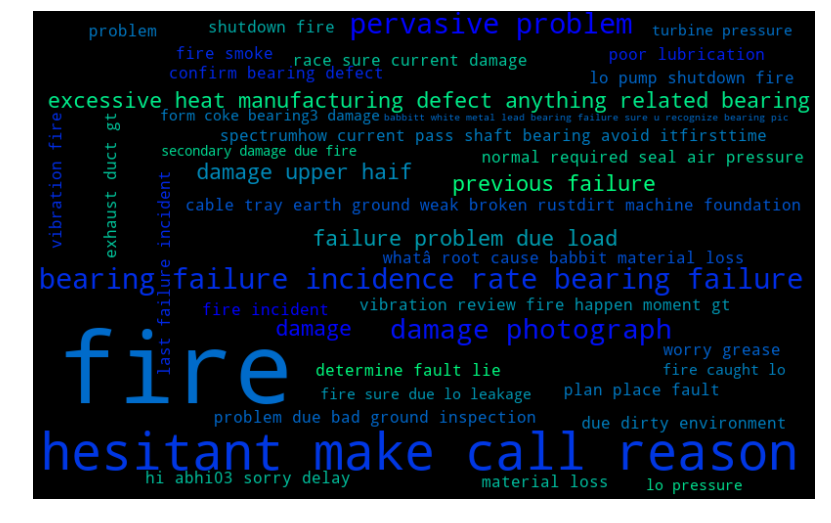

In [72]:
# Failure Mode Word Cloud
freqDistRDDPos = failMode.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

df_fDistPos = freqDistRDDPos.toDF() #converting RDD to spark dataframe
df_fDistPos.createOrReplaceTempView("myTablePos") 
dfPos = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTablePos limit 40") #renaming columns 
pandDPos = dfPos.toPandas() #converting spark dataframes to pandas dataframes

wordcloudConvertDFPos = pandDPos.set_index('Keywords').T.to_dict('records')
wordcloudPos = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='winter').generate_from_frequencies(dict(*wordcloudConvertDFPos))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloudPos, interpolation="bilinear")
plt.axis('off')
plt.show()

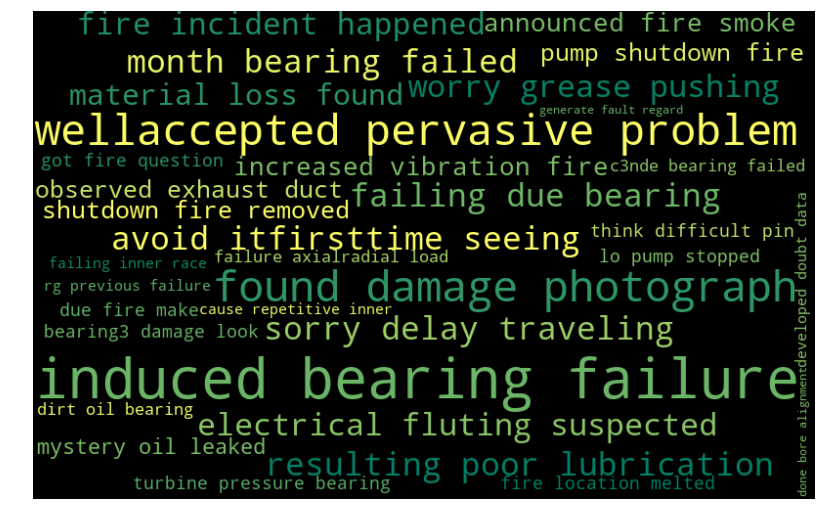

In [68]:
# Failure Cause Word Cloud
freqDistRDDNeg = failCause.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

df_fDistNeg = freqDistRDDNeg.toDF() #converting RDD to spark dataframe
df_fDistNeg.createOrReplaceTempView("myTableNeg") 
dfNeg = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTableNeg limit 40") #renaming columns 
pandDNeg = dfNeg.toPandas() #converting spark dataframes to pandas dataframes

wordcloudConvertDFNeg = pandDNeg.set_index('Keywords').T.to_dict('records')
wordcloudNeg = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='summer').generate_from_frequencies(dict(*wordcloudConvertDFNeg))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloudNeg, interpolation="bilinear")
plt.axis('off')
plt.show()

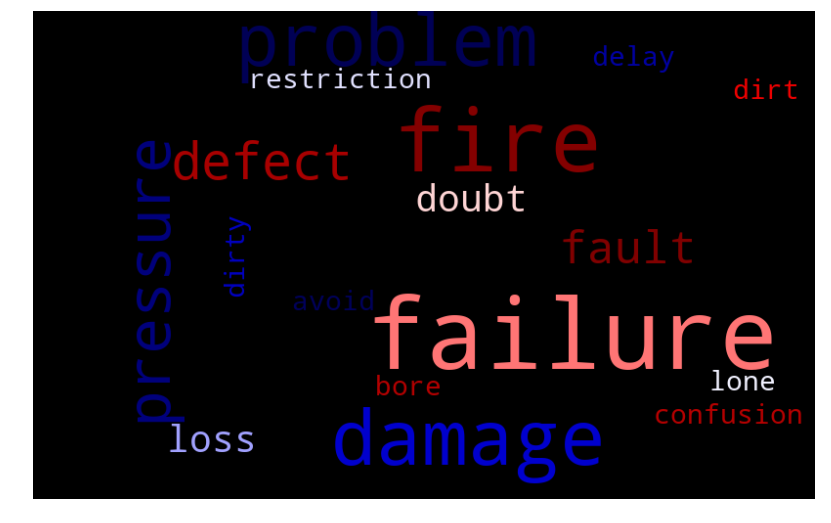

In [74]:
# Failure Event Word Cloud
freqDistRDDPos = failEvent.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)

df_fDistPos = freqDistRDDPos.toDF() #converting RDD to spark dataframe
df_fDistPos.createOrReplaceTempView("myTablePos") 
dfPos = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from myTablePos limit 40") #renaming columns 
pandDPos = dfPos.toPandas() #converting spark dataframes to pandas dataframes

wordcloudConvertDFPos = pandDPos.set_index('Keywords').T.to_dict('records')
wordcloudPos = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='seismic').generate_from_frequencies(dict(*wordcloudConvertDFPos))
plt.figure(figsize=(14, 10))    
plt.imshow(wordcloudPos, interpolation="bilinear")
plt.axis('off')
plt.show()